# Mapping the task variables onto neural embedding space

## imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:

import torch
from neural_plot_ult import *
from matplotlib import pyplot as plt
import numpy as np
import cebra
from pathlib import Path
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch
from IPython.display import clear_output
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:

import configparser
config = configparser.ConfigParser()
config.read_file(open('../../privateconfig'))
resdir = Path(config['Datafolder']['data'])
workdir = Path(config['Codefolder']['workspace'])
os.chdir(workdir)

In [4]:

from notification import notify

## load data and neural embedding model

In [5]:
datafile='0401normz.nbedata'
embeddingfile='0401normz_0401.pt'

In [6]:
# real data
with open(f'{workdir}/test/neural/cebra/{datafile}', 'rb') as f:
    (neural_data, continuous_label, var_names) = pickle.load(f)

var_names

['sess_latentff_hori',
 'sess_latentff_vert',
 'sess_eye_hori',
 'sess_eye_vert',
 'sess_latentb_hori',
 'sess_latentb_vert',
 '(sess_angle_from_start)',
 'sess_ll_t',
 'sess_t',
 'sess_err',
 'sess_err_belief',
 'sess_angle_from_start_belief',
 'belief_heading']

In [7]:
# load trained model
single_cebra_model = cebra.CEBRA.load(
    f'{workdir}/test/neural/cebra/{embeddingfile}')

# %matplotlib inline
# ax=cebra.plot_loss(single_cebra_model)
# ax.set_title('training loss')

# ax=cebra.plot_temperature(single_cebra_model)
# ax.set_title('temperature')

In [8]:
embedding = single_cebra_model.transform(neural_data)

/home/yc/miniconda3/envs/ffneural/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,


# train task var --> neural embedding model

In [9]:
continuous_label.shape, embedding.shape

((18985, 13), (18985, 3))

In [10]:

x_data = continuous_label
y_data = embedding

# Define the ratio of data to use for validation
validation_ratio = 0.2  # 20% of the data will be used for validation

# Calculate the number of samples for the validation set
num_validation_samples = int(validation_ratio * len(x_data))

# Generate random indices for the validation set
validation_indices = np.random.choice(
    len(x_data), num_validation_samples, replace=False)

# Create training and validation datasets
x_train = np.delete(x_data, validation_indices, axis=0)
y_train = np.delete(y_data, validation_indices, axis=0)

x_val = x_data[validation_indices]
y_val = y_data[validation_indices]

# Convert numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

x_val_tensor = torch.tensor(x_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

# Create TensorDatasets for training and validation
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Define batch size
batch_size = 256

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

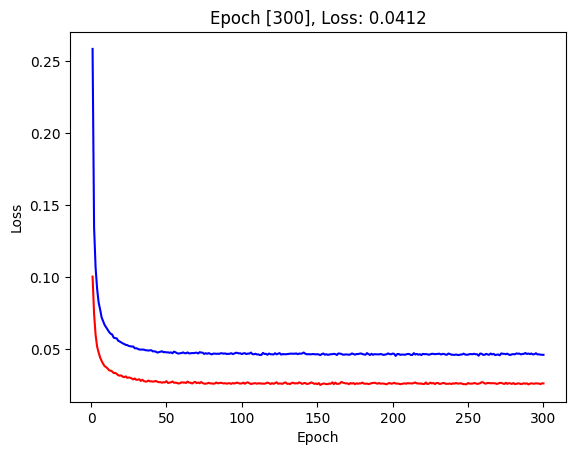

In [28]:

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        # Adjust input and hidden layer size as needed
        self.fc1 = nn.Linear(13, 64)
        self.dropout = nn.Dropout(0.5)  # Add dropout with probability 0.5
        self.fc2 = nn.Linear(64, 3)  # Adjust output layer size as needed

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


model = MyModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Training loop
trainloss, valloss = [], []
num_epochs = 300
for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set model to training mode
    epoch_loss = 0.
    num_batches = 0
    for batch_x, batch_y in train_loader:
        num_batches += 1
        # Forward pass
        outputs = model(batch_x)

        # Compute loss
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    trainloss.append(epoch_loss/num_batches)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        val_loss_total = 0
        num_val_batches = 0
        for batch_x_val, batch_y_val in val_loader:
            # Forward pass
            val_outputs = model(batch_x_val)

            # Compute loss
            val_loss = criterion(val_outputs, batch_y_val)
            val_loss_total += val_loss.item()
            num_val_batches += 1

        # Print average validation loss
        avg_val_loss = val_loss_total / num_val_batches
        valloss.append(avg_val_loss)

        # print(f"Epoch [{epoch+1}/1000], Loss: {loss.item():.4f}")
        clear_output(wait=True)
        plt.plot(range(1, epoch+2), trainloss, color='blue', label='train')
        plt.plot(range(1, epoch+2), valloss, color='red', label='val')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f"Epoch [{epoch+1}], Loss: {loss.item():.4f}")
        plt.show()

## verify the trained model

In [29]:
model.eval()
with torch.no_grad():
    beh_embedding = model(torch.Tensor(continuous_label).to(device))

newembedding = beh_embedding.cpu().numpy()

## 2d embedding

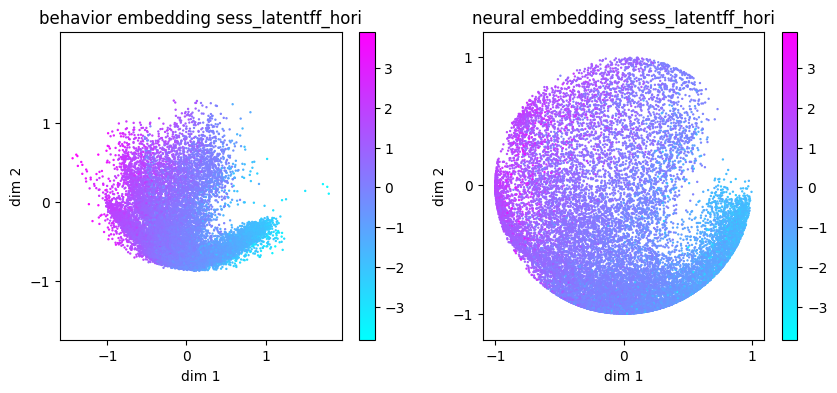

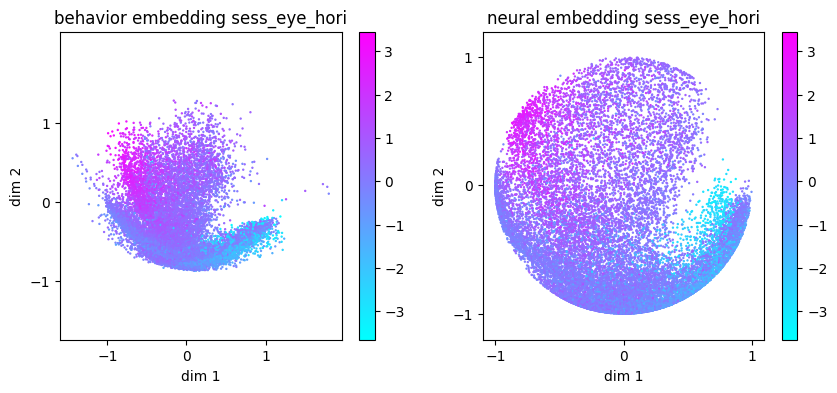

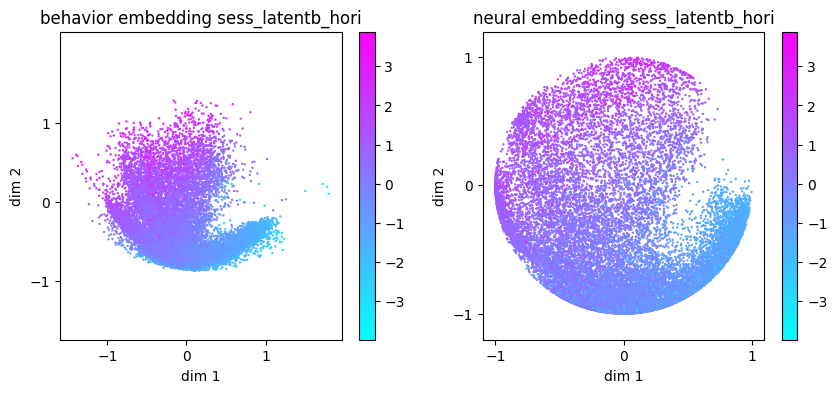

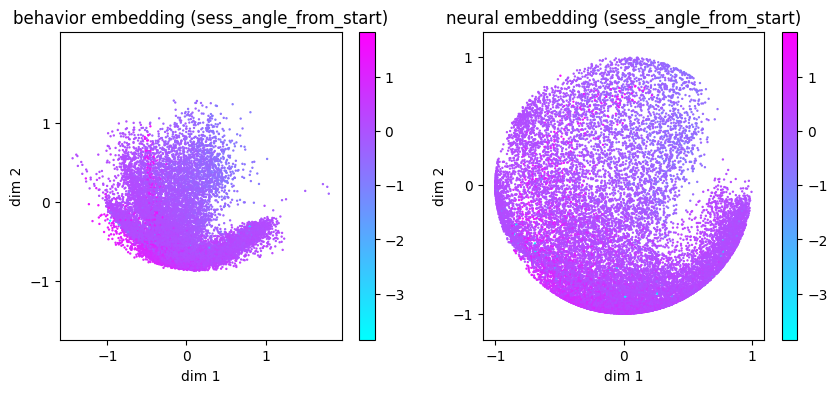

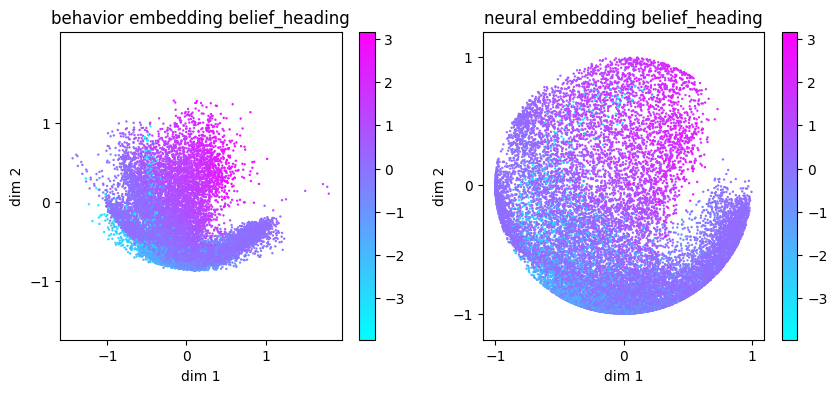

In [30]:

%matplotlib inline

for beh_idx in [0,2,4,6,12]:
    
    fig = plt.figure(figsize=(10,4))
    ax1 = plt.subplot(121)
    ax1=plot_embedding2d(ax1, newembedding, continuous_label, beh_idx=beh_idx)
    ax1.set_title(f'behavior embedding {var_names[beh_idx]}')
    ax1 = plt.subplot(122)
    ax1=plot_embedding2d(ax1, embedding, continuous_label, beh_idx=beh_idx)
    ax1.set_title(f'neural embedding {var_names[beh_idx]}')

    plt.show()

## 2d embedding constrast

hori sess_latentff_hori 0 sess_eye_hori 2


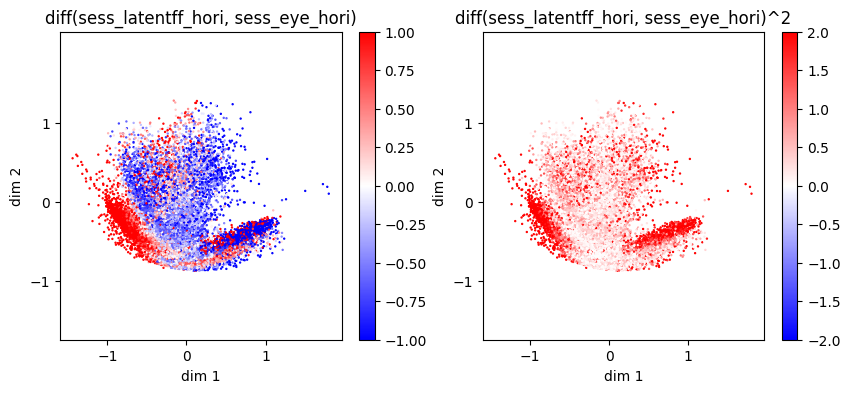

hori sess_latentff_hori 0 sess_latentb_hori 4


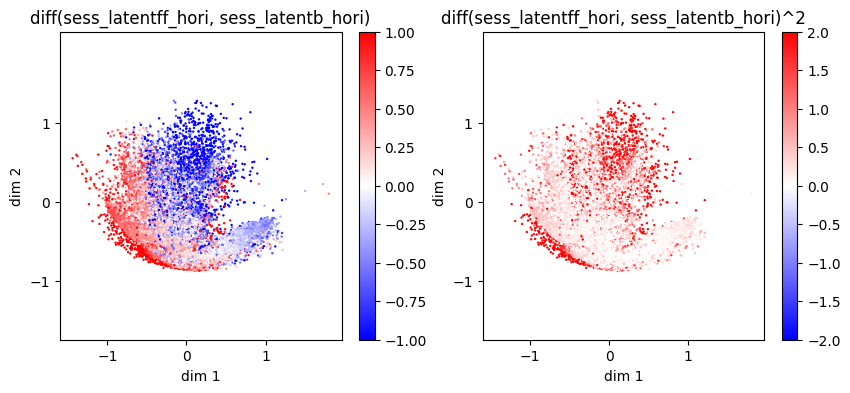

hori sess_eye_hori 2 sess_latentb_hori 4


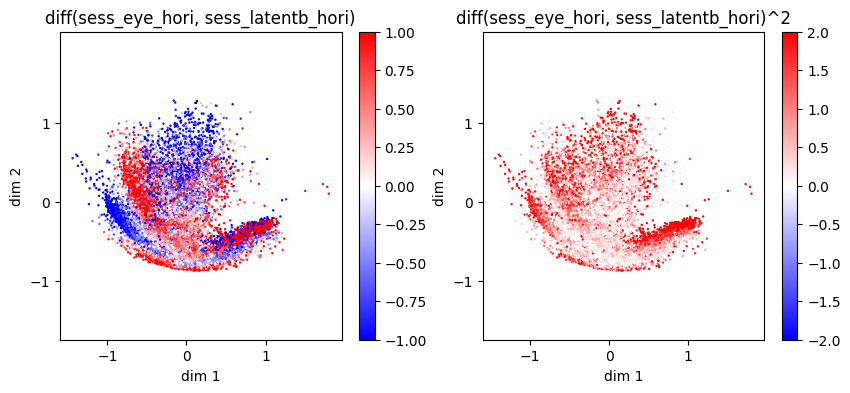

vert sess_latentff_vert 1 sess_eye_vert 3


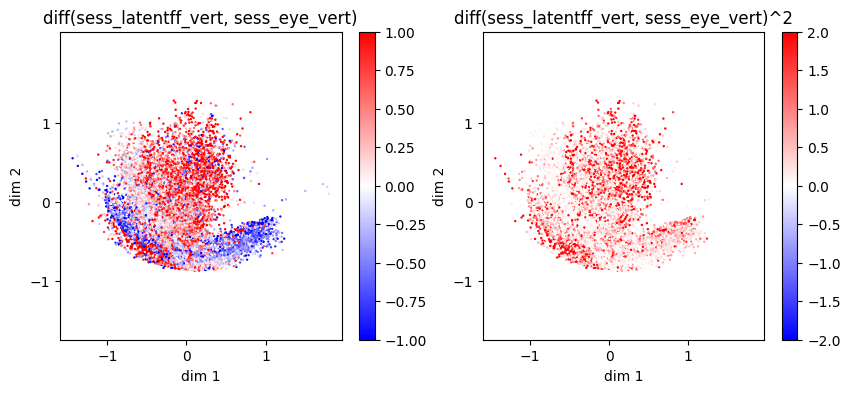

vert sess_latentff_vert 1 sess_latentb_vert 5


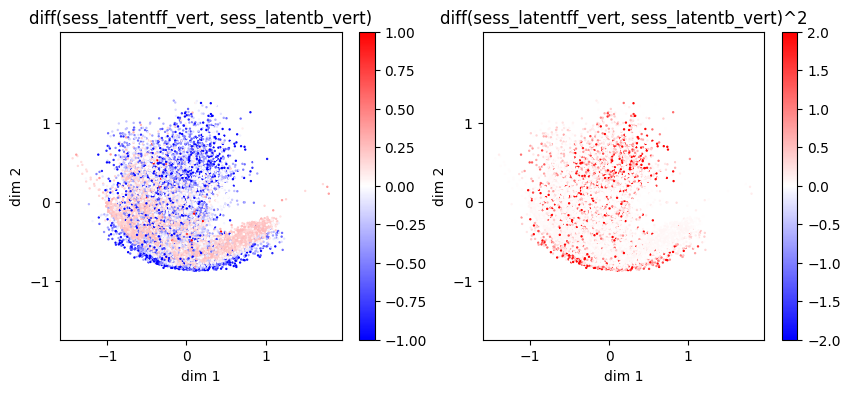

vert sess_eye_vert 3 sess_latentb_vert 5


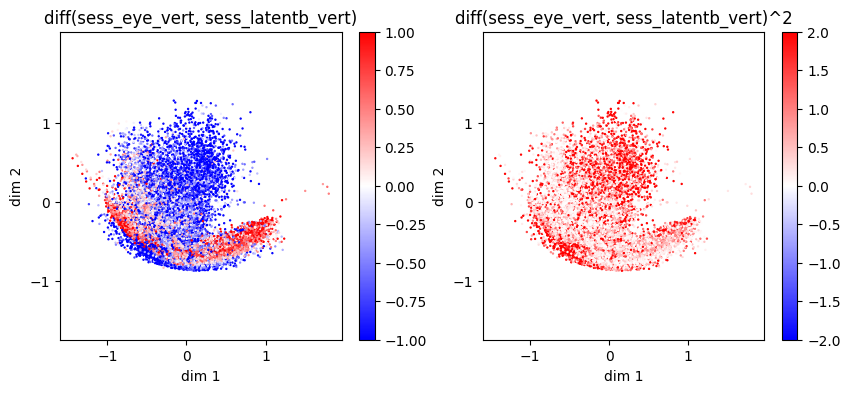

In [31]:
# generate relavent figure (eg, hori to hori)
%matplotlib inline
for tag in ['hori', 'vert']:
    for taskvar1 in range(len(var_names)):
        for taskvar2 in range(taskvar1,len(var_names)):
            if taskvar1==taskvar2: continue
            if tag in var_names[taskvar1] and tag in var_names[taskvar2]:
                print(tag, var_names[taskvar1],taskvar1, var_names[taskvar2],taskvar2)

                fig = plt.figure(figsize=(10,4))

                ax = plt.subplot(121)
                plot_embedding2d_contrast(ax, newembedding, continuous_label, gray = False, beh_idx=(taskvar1,taskvar2), vmin=-1, vmax=1)
                ax.set_title(f'diff({var_names[taskvar1]}, {var_names[taskvar2]})')

                ax = plt.subplot(122)
                plot_embedding2d_contrast(ax, newembedding, continuous_label, gray = False, beh_idx=(taskvar1,taskvar2),contrast=lambda x, y: (x - y)**2, vmin=0, vmax=2)
                ax.set_title(f'diff({var_names[taskvar1]}, {var_names[taskvar2]})^2')

                plt.show()

# train neural embedding --> task var

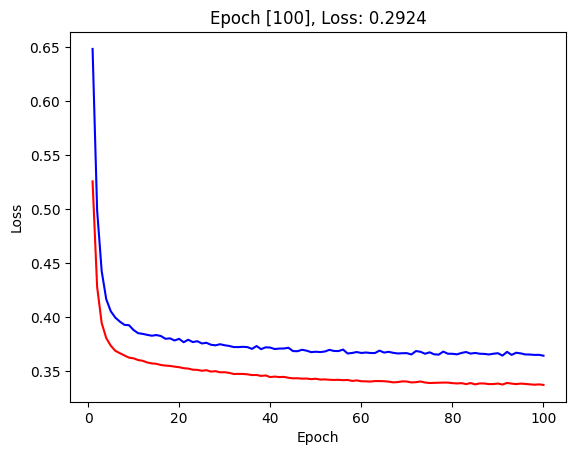

In [15]:
# the same model but revert x and y

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        # Adjust input and hidden layer size as needed
        self.fc1 = nn.Linear(3, 64)
        self.dropout = nn.Dropout(0.5)  # Add dropout with probability 0.5
        self.fc2 = nn.Linear(64, 13)  # Adjust output layer size as needed

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


model = MyModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Training loop
trainloss, valloss = [], []
num_epochs = 100
for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set model to training mode
    epoch_loss = 0.
    num_batches = 0
    for batch_x, batch_y in train_loader:
        num_batches += 1
        # Forward pass
        outputs = model(batch_y)

        # Compute loss
        loss = criterion(outputs, batch_x)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    trainloss.append(epoch_loss/num_batches)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        val_loss_total = 0
        num_val_batches = 0
        for batch_x_val, batch_y_val in val_loader:
            # Forward pass
            val_outputs = model(batch_y_val)

            # Compute loss
            val_loss = criterion(val_outputs, batch_x_val)
            val_loss_total += val_loss.item()
            num_val_batches += 1

        # Print average validation loss
        avg_val_loss = val_loss_total / num_val_batches
        valloss.append(avg_val_loss)

        # print(f"Epoch [{epoch+1}/1000], Loss: {loss.item():.4f}")
        clear_output(wait=True)
        plt.plot(range(1, epoch+2), trainloss, color='blue', label='train')
        plt.plot(range(1, epoch+2), valloss, color='red', label='val')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f"Epoch [{epoch+1}], Loss: {loss.item():.4f}")
        plt.show()

## verify the trained model

In [16]:
# real data inference
model.eval()
with torch.no_grad():
    predicted_taskvar = model(torch.Tensor(embedding).to(device))
predicted_taskvar = predicted_taskvar.cpu().numpy()

# whole data range inference
grid_size = 100
x = torch.linspace(-1, 1, grid_size)
y = torch.linspace(-1, 1, grid_size)
X, Y = torch.meshgrid(x, y)
radius = torch.sqrt(X**2 + Y**2)
X_circle = X[radius <= 1]
Y_circle = Y[radius <= 1]
embedding_span = torch.vstack(
    [(X_circle), (Y_circle), torch.zeros_like((X_circle))]).T

model.eval()
with torch.no_grad():
    predicted_taskvar_span = model(torch.Tensor(embedding_span).to(device))
predicted_taskvar_span = predicted_taskvar_span.cpu().numpy()

/home/yc/miniconda3/envs/ffneural/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## 2d embedding

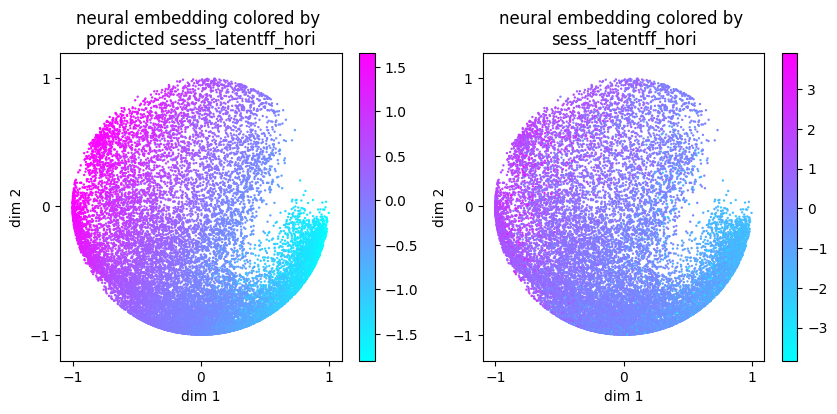

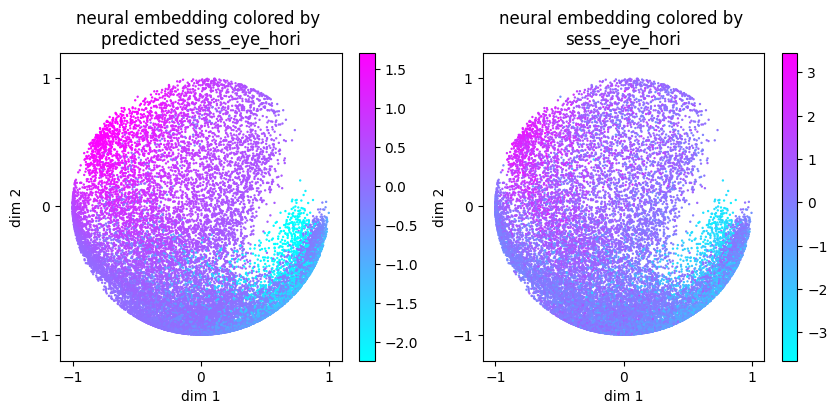

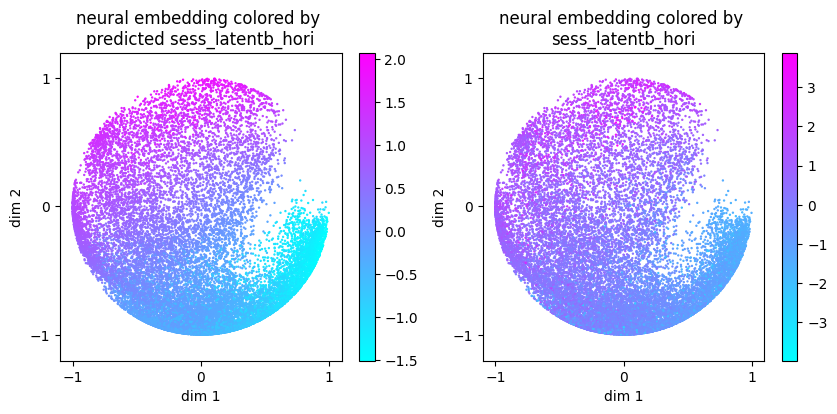

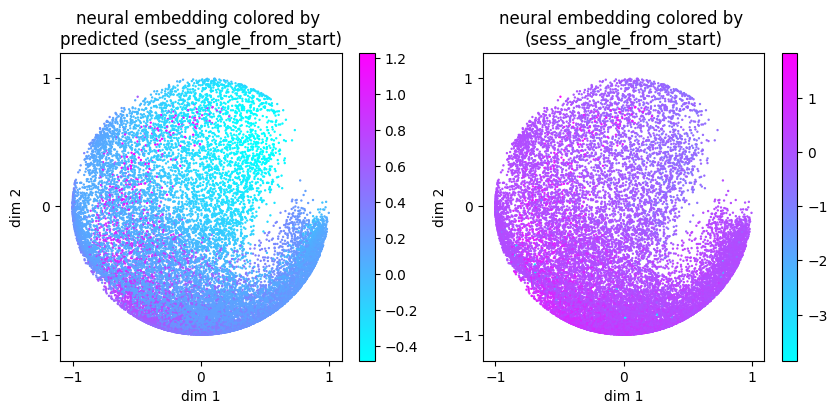

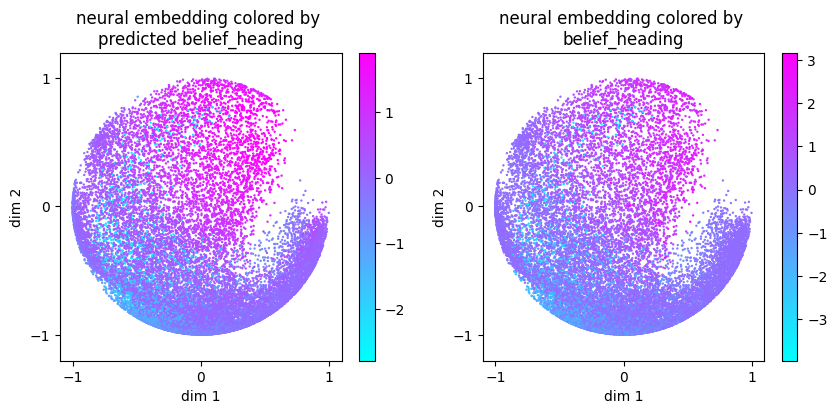

In [17]:

%matplotlib inline

for beh_idx in [0,2,4,6,12]:
    
    fig = plt.figure(figsize=(10,4))
    ax1 = plt.subplot(121)
    ax1=plot_embedding2d(ax1, embedding, predicted_taskvar, beh_idx=beh_idx)
    ax1.set_title(f'neural embedding colored by \npredicted {var_names[beh_idx]}')
    ax1 = plt.subplot(122)
    ax1=plot_embedding2d(ax1, embedding, continuous_label, beh_idx=beh_idx)
    ax1.set_title(f'neural embedding colored by \n{var_names[beh_idx]}')

    plt.show()

## 2d embedding span

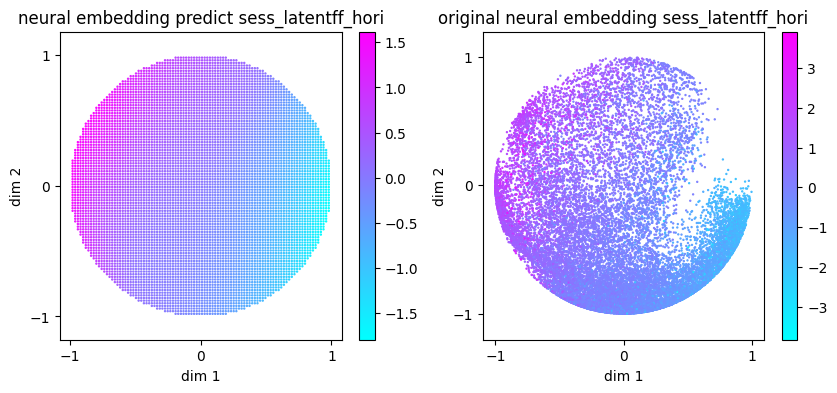

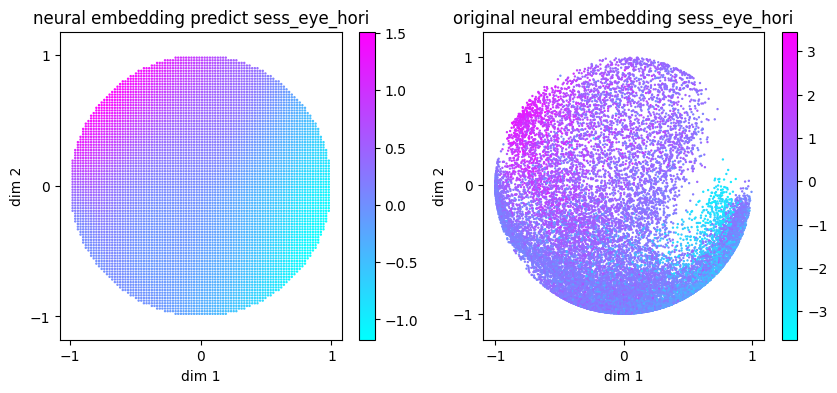

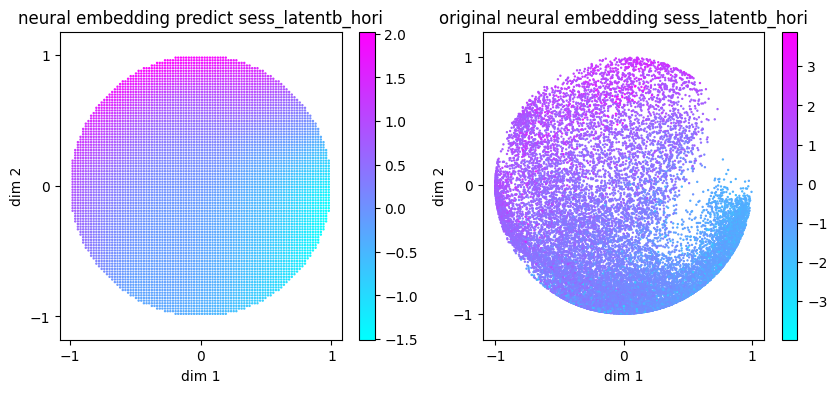

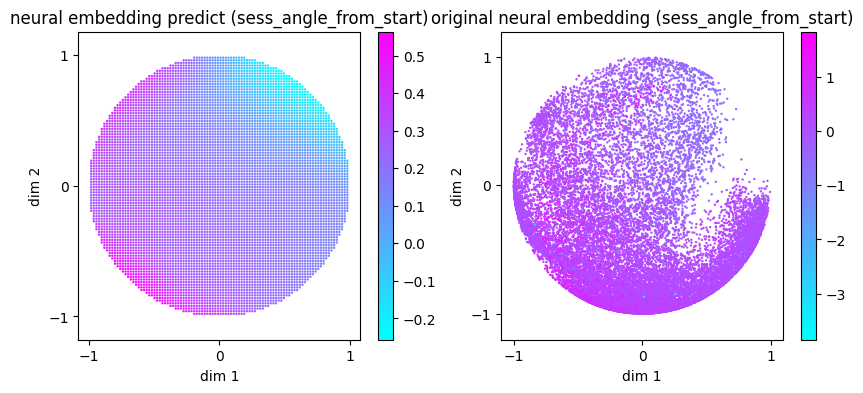

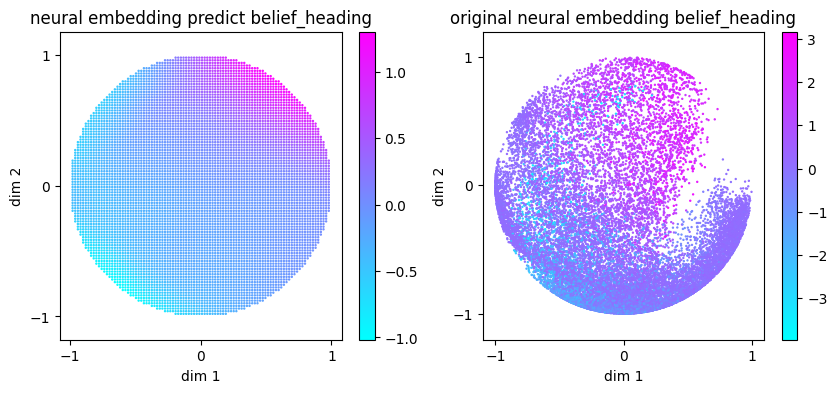

In [18]:

%matplotlib inline

for beh_idx in [0,2,4,6,12]:
    
    fig = plt.figure(figsize=(10,4))
    ax1 = plt.subplot(121)
    ax1=plot_embedding2d(ax1, embedding_span, predicted_taskvar_span, beh_idx=beh_idx)
    ax1.set_title(f'neural embedding predict {var_names[beh_idx]}')
    ax1 = plt.subplot(122)
    ax1=plot_embedding2d(ax1, embedding, continuous_label, beh_idx=beh_idx)
    ax1.set_title(f'original neural embedding {var_names[beh_idx]}')

    plt.show()

## 2d embedding contrast

hori sess_latentff_hori 0 sess_eye_hori 2


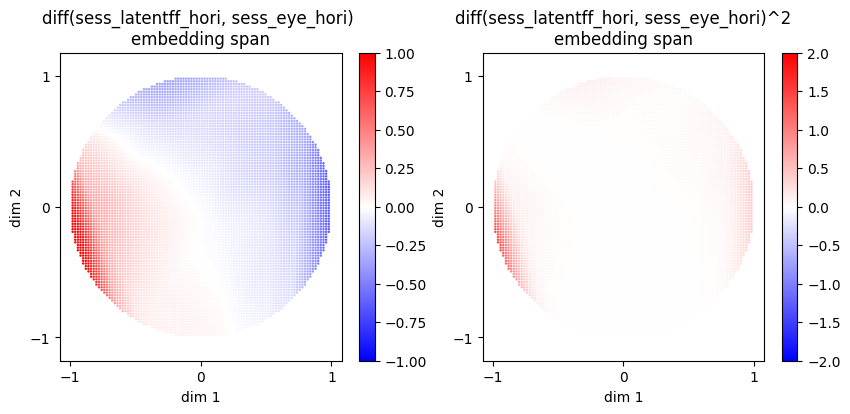

hori sess_latentff_hori 0 sess_latentb_hori 4


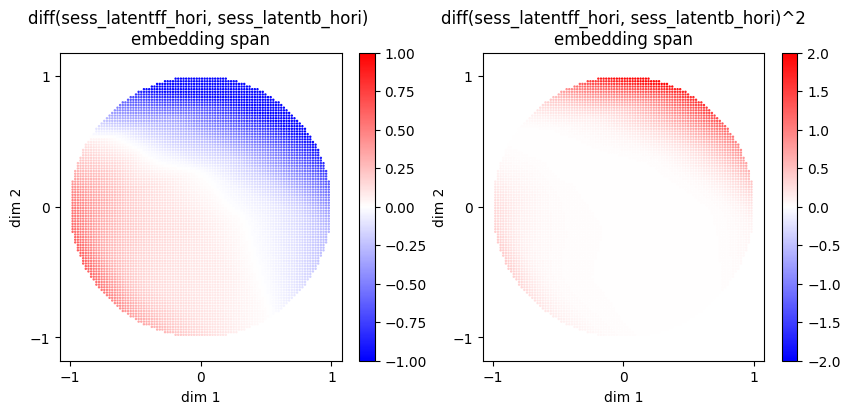

hori sess_eye_hori 2 sess_latentb_hori 4


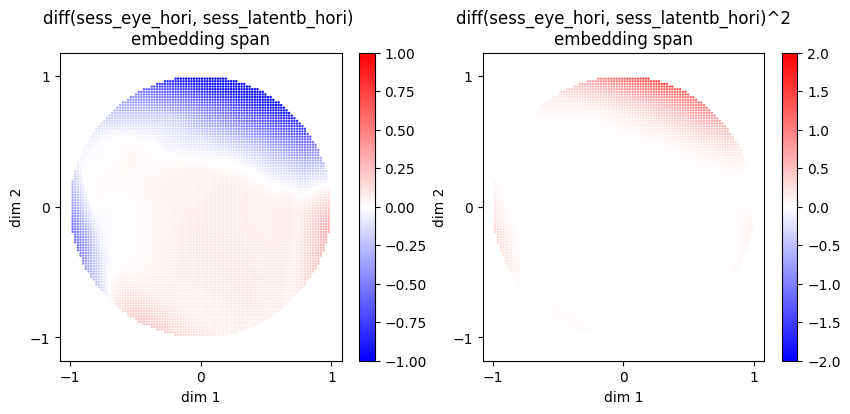

vert sess_latentff_vert 1 sess_eye_vert 3


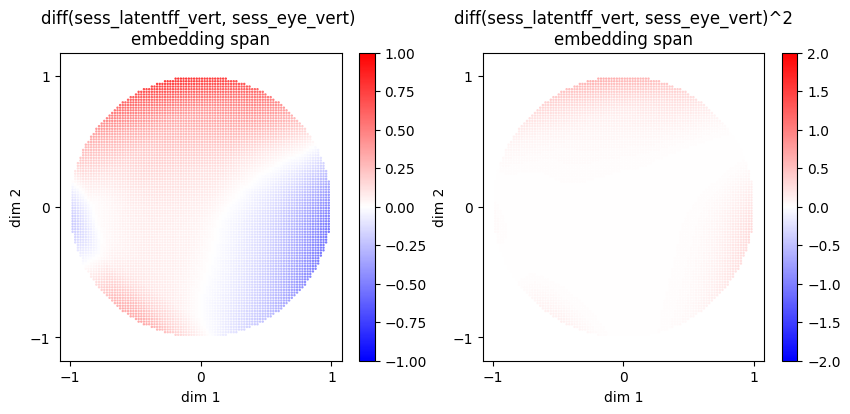

vert sess_latentff_vert 1 sess_latentb_vert 5


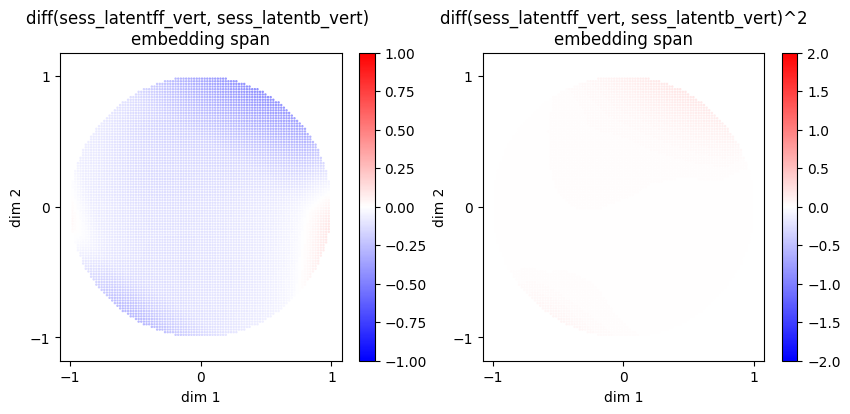

vert sess_eye_vert 3 sess_latentb_vert 5


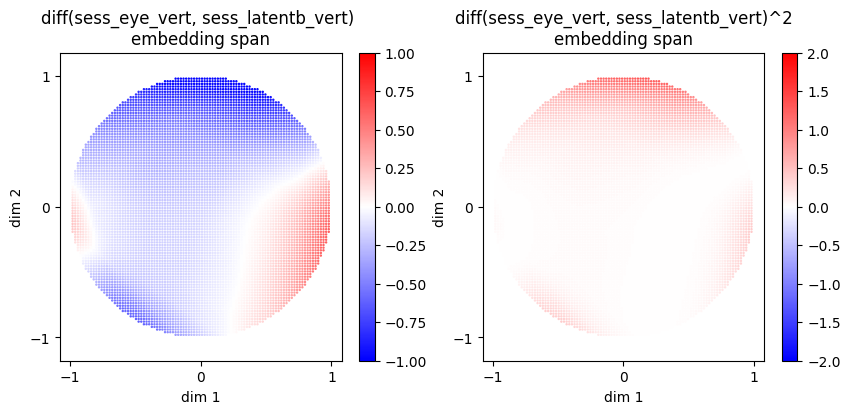

In [19]:
# generate relavent figure (eg, hori to hori)
%matplotlib inline
for tag in ['hori', 'vert']:
    for taskvar1 in range(len(var_names)):
        for taskvar2 in range(taskvar1,len(var_names)):
            if taskvar1==taskvar2: continue
            if tag in var_names[taskvar1] and tag in var_names[taskvar2]:
                print(tag, var_names[taskvar1],taskvar1, var_names[taskvar2],taskvar2)

                fig = plt.figure(figsize=(10,4))

                ax = plt.subplot(121)
                plot_embedding2d_contrast(ax, embedding_span, predicted_taskvar_span, gray = False, beh_idx=(taskvar1,taskvar2), vmin=-1, vmax=1)
                ax.set_title(f'diff({var_names[taskvar1]}, {var_names[taskvar2]}) \nembedding span')

                ax = plt.subplot(122)
                plot_embedding2d_contrast(ax, embedding_span, predicted_taskvar_span, gray = False, beh_idx=(taskvar1,taskvar2),contrast=lambda x, y: (x - y)**2, vmin=0, vmax=2)
                ax.set_title(f'diff({var_names[taskvar1]}, {var_names[taskvar2]})^2\nembedding span' )

                plt.show()